# Prediction for one composition

(c) Charles Le Losq and contributors, 2021-2024
see embedded licence file

In this notebook, we show how one can ask for specific predictions for a given composition.

### Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd, numpy as np

# for plotting
import matplotlib.pyplot as plt 

# import imelt and torch
import imelt as imelt

import torch

# we will work on CPU there
device=torch.device('cpu')

# we load the model
ds = imelt.data_loader()
imelt_model = imelt.load_pretrained_bagged()

# What is the composition of interest ?

Here we reproduce the prediction for albite glass, change for your case.

The composition should be provided in percents. Use the `composition_mole` to indicate if the composition is in mole percents (True) or weight percents (False).

In [2]:
composition = imelt.generate_query_single(sio2 = 75.0, 
                                          al2o3 = 12.5,
                                          na2o = 12.5, 
                                          k2o = 0.0,
                                          mgo = 0.0,
                                          cao = 0.0, 
                                   composition_mole=True)

# Viscosity prediction

For viscosity predictions, you first need to determine the temperature range, and then the equation you want to use.

1/ Select the temperature range


In [3]:
T_start = 2000 # MODIFY THIS, lower T limit
T_stop = 3000 # MODIFY THIS, upper T limit

T_range = np.arange(T_start, T_stop, 1.0)

2/ select the equation, among: 
    
    - ag > Adam-Gibbs
    - am > Avramov Milchev
    - myega > MYEGA
    - tvf > Vogel-Tamman-Fulcher
    - cg > Free Volume

In [4]:
equation = "ag" # MODIFY THIS

### Prediction step:

warning : for viscosity you need to duplicate the composition array to get as many lines as the lenght of T_range.

It is simpler for other predictions, no need to do that.


In [5]:
viscosity = imelt_model.predict(equation, composition, T_range)

# Other predictions

Basically, the model object, here called imelt_model, has a `predict` method. You can pass many different parameters here to calculate various properties/variables. We show a brief example here, look at the source code of i-Melt (function `imelt.model`) to get further ideas!

Error bars are estimated using MC Dropout, with 20*10 sampling so 200 models. Here the number of predictions is limited to ensure that the notebook runs smoothly on any computer. Of course, you can increase the number of samples to get a better estimate of the median and quantiles. Best practice will be to correct the error bars on observed properties with conformal predictions, as discussed in the paper and as shown below.

In [6]:
# below we activate sampling, to get MC Dropout estimates of error bars.
# those are not corrected by conformal predictions (see paper for details and implications)
tg = imelt_model.predict("tg",composition, sampling=True, n_sample=20)
sctg = imelt_model.predict("sctg", composition, sampling=True, n_sample=20)
fragility = imelt_model.predict("fragility", composition, sampling=True, n_sample=20)
density = imelt_model.predict("density_glass", composition, sampling=True, n_sample=20)
ri = imelt_model.predict("sellmeier", composition, lbd=np.array([589.0*1e-3]), sampling=True, n_sample=20) # warning: enter wavenumber in microns

A_TVF = imelt_model.predict("a_tvf", composition, sampling=True, n_sample=20)
B_TVF = imelt_model.predict("b_tvf", composition, sampling=True, n_sample=20)
C_TVF = imelt_model.predict("c_tvf", composition, sampling=True, n_sample=20)

print('')
print('Results for composition with mol fractions')
print('{} SiO2, {} Al2O3, {} Na2O, {} K2O, {} MgO, {} CaO'.format(composition[0,0],composition[0,1],composition[0,2],
                                                                 composition[0,3],composition[0,4],composition[0,5]))
print('')
print('Tg is of {:.0f} +/- {:.0f}'.format(tg.mean(axis=1)[0], tg.std(axis=1)[0]))
print('Sconf at Tg is of {:.1f} +/- {:.1f}'.format(sctg.mean(axis=1)[0], sctg.std(axis=1)[0]))
print('')
print('Fragility is of {:.1f} +/- {:.1f}'.format(fragility.mean(axis=1)[0], fragility.std(axis=1)[0]))
print('Density is of {:.3f} +/- {:.3f}'.format(density.mean(axis=1)[0], density.std(axis=1)[0]))
print('Refractive Index at 589 nm is of {:.3f} +/- {:.3f}'.format(ri.mean(axis=1)[0], ri.std(axis=1)[0]))
print('')
print('Parameter A for VFT is of {:.2f}'.format(A_TVF.mean(axis=1)[0]))
print('Parameter B for VFT is of {:.1f}'.format(B_TVF.mean(axis=1)[0]))
print('Parameter C for VFT is of {:.1f}'.format(C_TVF.mean(axis=1)[0]))


Results for composition with mol fractions
0.75 SiO2, 0.125 Al2O3, 0.125 Na2O, 0.0 K2O, 0.0 MgO, 0.0 CaO

Tg is of 1081 +/- 14
Sconf at Tg is of 8.9 +/- 0.7

Fragility is of 28.1 +/- 1.6
Density is of 2.373 +/- 0.009
Refractive Index at 589 nm is of 1.490 +/- 0.003

Parameter A for VFT is of -5.71
Parameter B for VFT is of 13120.8
Parameter C for VFT is of 339.7


## Raman spectra

You can also predict Raman spectra:

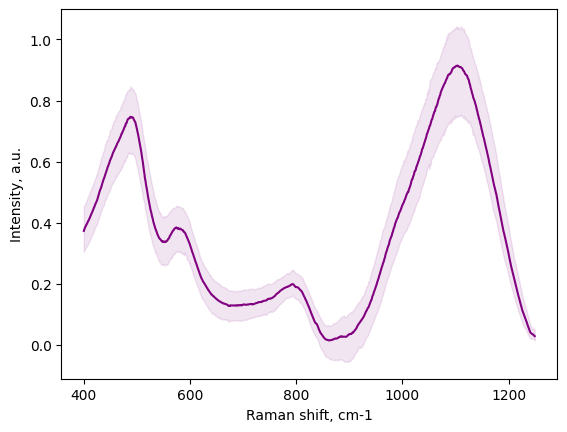

In [7]:
raman = imelt_model.predict("raman_pred", composition, sampling=True, n_sample=20)

#
# Plotting the Raman spectra
#
plt.figure()
# median spectrum for this composition
plt.plot(ds.x_raman_shift,np.quantile(raman, 0.50, axis=2).ravel(), c="purple")

# and we plot the shaded area between the 2.5 and 97.5 confidence intervals
plt.fill_between(ds.x_raman_shift, 
                 np.quantile(raman, 0.025, axis=2).ravel(), # low boundary (2.5 quantile)
                 np.quantile(raman, 0.975, axis=2).ravel(), # high boundary (97.5 quantile)
                 alpha=0.1, color="purple") 
plt.xlabel("Raman shift, cm-1")
plt.ylabel("Intensity, a.u.")
plt.show()

### Error bar scaling

The reported confidence intervals above are from MC Dropout. Those may not be fully realistic. The use of conformal prediction allows rescaling the confidence intervals returned by MC Dropout for observed properties.

Below we provide an example of error bar rescaling on density predictions with the package aws-fortuna:

In [8]:
# for uncertainty calibration
from fortuna.conformal.regression.quantile import QuantileConformalRegressor

# we use the validation density dataset as a calibration dataset
x_cal= ds.x_density_valid
y_cal= ds.y_density_valid

y_cal_pred = imelt_model.predict("density_glass", x_cal, sampling=True, n_sample=20)

# correction of confidence intervals with Conformal Regression from aws fortuna
density_cred_intervals = QuantileConformalRegressor().conformal_interval(
val_lower_bounds=np.quantile(y_cal_pred,0.025, axis=1), # calibration predicted lower bound
val_upper_bounds=np.quantile(y_cal_pred,0.975, axis=1), # calibration predicted upper bound
val_targets=y_cal.detach().numpy(), # calibration target
test_lower_bounds=np.quantile(density,0.025, axis=1), # unseen prediction
test_upper_bounds=np.quantile(density,0.975, axis=1), # unseen prediction
error=0.05 # desired precision
)

print("The 2.5 and 97.5 confidence intervals before rescaling are {:0.2f} and {:0.2f}.".format(np.quantile(density,0.025),
                                                                                              np.quantile(density,0.975)))
print("The 2.5 and 97.5 confidence intervals after rescaling are {:0.2f} and {:0.2f}.".format(density_cred_intervals[0][0],
                                                                                              density_cred_intervals[0][1]))



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The 2.5 and 97.5 confidence intervals before rescaling are 2.36 and 2.39.
The 2.5 and 97.5 confidence intervals after rescaling are 2.35 and 2.39.


This can also be applied on Raman spectra predictions. For this we need to recalculate the c.i. at each frequency in a loop.

In [9]:
# we use the validation density dataset as a calibration dataset
x_cal= ds.x_raman_valid
y_cal= ds.y_raman_valid

# get calibration predictions
y_cal_pred = imelt_model.predict("raman_pred", x_cal, sampling=True, n_sample=20)

# record their shape
y_sh = y_cal_pred.shape

# record the shape of the prediction target
raman_sh = raman.shape

# create an aaray to store the new c.i.
raman_cred_intervals = np.zeros((raman_sh[0], raman_sh[1], 2))

# we correct the c.i. at each Raman shift
for i in range(raman_sh[1]):
    # correction of confidence intervals with Conformal Regression from aws fortuna
    cred_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=np.quantile(y_cal_pred[:,i,:].reshape(y_sh[0],y_sh[2]),0.025, axis=1), # calibration predicted lower bound
    val_upper_bounds=np.quantile(y_cal_pred[:,i,:].reshape(y_sh[0],y_sh[2]),0.975, axis=1), # calibration predicted upper bound
    val_targets=y_cal[:,i].reshape(-1,1).detach().numpy(), # calibration target
    test_lower_bounds=np.quantile(raman[:,i,:].reshape(raman_sh[0],raman_sh[2]),0.025, axis=1), # unseen prediction
    test_upper_bounds=np.quantile(raman[:,i,:].reshape(raman_sh[0],raman_sh[2]),0.975, axis=1), # unseen prediction
    error=0.05 # desired precision
    )
    
    raman_cred_intervals[:,i,:] = cred_intervals
    

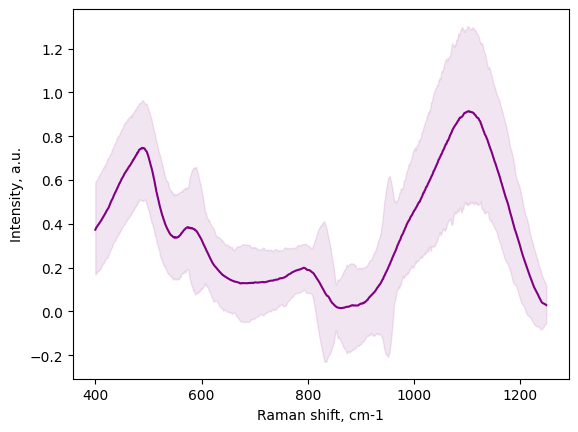

In [10]:
#
# Plotting the Raman spectra
#
plt.figure()
# median spectrum for this composition
plt.plot(ds.x_raman_shift,np.quantile(raman, 0.50, axis=2).ravel(), c="purple")

plt.fill_between(ds.x_raman_shift, 
                 raman_cred_intervals[0,:,0], # low boundary (2.5 quantile)
                 raman_cred_intervals[0,:,1], # high boundary (97.5 quantile)
                 alpha=0.1, color="purple") 
plt.xlabel("Raman shift, cm-1")
plt.ylabel("Intensity, a.u.")
plt.show()